# 15wk-1: 강화학습 (4) – LunarLander, A1, A2

최규빈  
2024-06-10

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/15wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

# 2. Imports

In [1]:
#!apt-get install swig
#!pip install gymnasium[box2d]
import gymnasium as gym
#--#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import IPython
#--#
import collections
import random
#--#
import torch

In [2]:
def show(ims,jump=10):
    ims = ims[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
        ax.imshow(ims[i])
    ani = FuncAnimation(fig,update,frames=len(ims))
    display(IPython.display.HTML(ani.to_jshtml()))

# 3. 예비학습

## A. `collections.deque`

`-` `collections.deque` 의 기능

In [3]:
a = collections.deque([12,21,33], maxlen = 5)
a

In [4]:
a.append(44)
a

In [5]:
a.append(55)
a

In [6]:
a.append(-66)
a

In [7]:
a.append(-40)
a

`-` 단점? numpy array 보다는 list 느낌임 (연산에 특화된건 아님)

In [8]:
a + 1

`-` 그렇지만 필요하다면 np.array 화 시킬 수 있음.

In [ ]:
np.array(a) + 1 

In [9]:
torch.tensor(a) + 1

`-` collection.deque 는 리플레이 버퍼를 구현할때 유용한 자료구조이다.

-   (우리가 했던) 기존방식: 모든 데이터를 저장하며 하나의 경험씩 학습함
-   리플레이버퍼: 최근 $N$개의 데이터를 저장하여 여러경험을 샘플링하여
    학습하는 방식
-   리플레이버퍼의 장점: 메모리를 아낄 수 있다, 다양한 종류의 경험을
    저장하고 무작위로 재사용하여 학습이 안정적으로 된다, “저장 -\> 학습
    -\> 저장” 순으로 반드시 실시간으로 학습할 필요가 없어서 병렬처리에
    용이하다, 강화학습에서 연속된 경험은 상관관계가 있을 수 있는데
    무작위 샘플로 이러한 상관관계를 제거할 수 있음

## B. `replay_buffer`

In [10]:
current_states = collections.deque([torch.tensor([0.23,0.1]),torch.tensor([0.34,0.2])],maxlen=5)
actions = collections.deque([torch.tensor(0), torch.tensor(1)],maxlen=5)
rewards = collections.deque([torch.tensor(3.43), torch.tensor(0.13)],maxlen=5)
next_states = collections.deque([torch.tensor([0.34,0.2]),torch.tensor([0.45,0.3])],maxlen=5)
terminations = collections.deque([torch.tensor(False),torch.tensor(False)],maxlen=5)

In [11]:
current_states, actions,rewards,next_states,terminations

In [12]:
memory = list(zip(current_states,actions,rewards,next_states,terminations))
memory

In [13]:
random.sample(memory,1)

# 4. LunarLander

`-` ref: <https://gymnasium.farama.org/environments/box2d/lunar_lander/>

`-` Lunar Lander: 요약

**Observation Space (관찰 공간)** – 8개의 연속적인 변수 1. 착륙선의 x
좌표 2. 착륙선의 y 좌표 3. 착륙선의 x 속도 4. 착륙선의 y 속도 5.
착륙선의 각도 6. 착륙선의 각속도 7. 왼쪽 다리가 땅에 닿아있는지 여부 (1
또는 0) 8. 오른쪽 다리가 땅에 닿아있는지 여부 (1 또는 0)

**Action Space (행동 공간)** – 4개의 이산적인 행동 1. {0 : 아무 행동도
하지 않음} 2. {1 : 메인 엔진 발사 (위로 밀어 올림)} 3. {2 : 왼쪽 엔진
발사 (오른쪽으로 기울임)} 4. {3 : 오른쪽 엔진 발사 (왼쪽으로 기울임)}

**Reward (보상)** - **거리 보상**: 착륙 패드에 가까울수록 보상 증가 -
**속도 보상**: 속도가 낮을수록 보상 증가 - **각도 보상**: 각도가 수직에
가까울수록 보상 증가 - **착륙 다리 보상**: 다리가 착륙 패드에 닿으면
보상 - **연료 사용 패널티**: 엔진 사용 시 패널티 - **안전한 착륙 보상**:
안정적으로 착륙 시 큰 보상 (+100~+140) - **충돌 패널티**: 착륙 패드
이외의 장소에 충돌 시 패널티 (-100)

`-` 환경생성

In [14]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
env 

`-` state_space

In [15]:
env.observation_space

In [16]:
env.observation_space.sample()

`-` action_space

In [17]:
env.action_space

In [18]:
env.action_space.sample()

`-` env.reset()

In [19]:
state, _ = env.reset()
state 

`-` env.render()

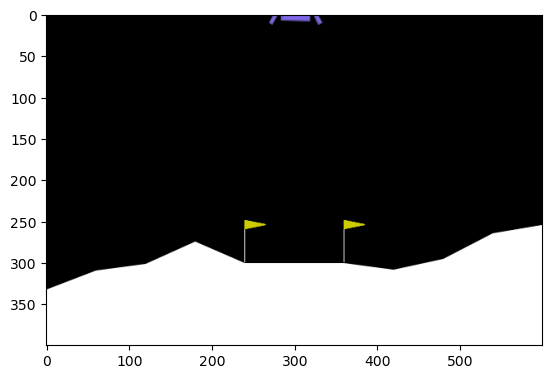

In [20]:
plt.imshow(env.render())

`-` env.step

In [21]:
env.step??

-   리턴되는 값은 (다음상태, 보상, 종료여부, 중단여부, 추가정보) 임..

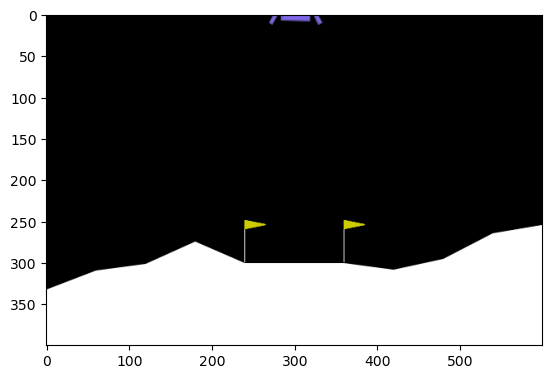

In [22]:
plt.imshow(env.render())

In [23]:
next_state, reward, terminated, _, _ = env.step(0)
next_state, reward, terminated

`-` play

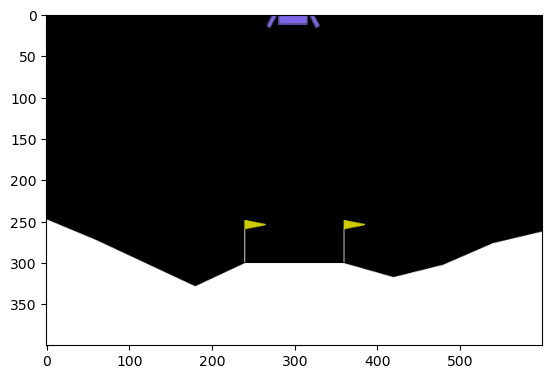

In [24]:
env.reset()
plt.imshow(env.render())

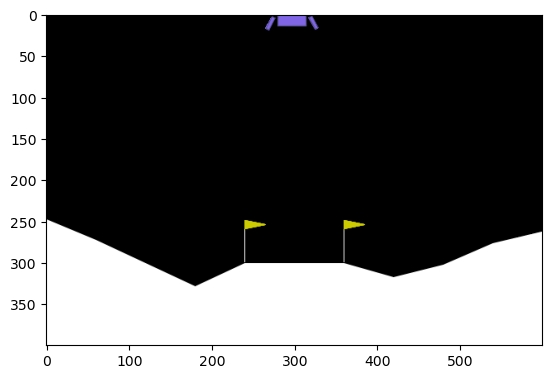

In [25]:
env.step(1)
plt.imshow(env.render())

-   0 : 아무행동도 하지 않음
-   1 : 왼쪽
-   2 : 위
-   3 : 오른쪽

# 5. 시각화

In [26]:
current_state, _ = env.reset()
ims = [] 
for t in range(500): 
    action = env.action_space.sample()
    next_state, reward, terminated, _, _ = env.step(action)
    ims.append(env.render()) 
    current_state = next_state 
    if terminated: break 

In [27]:
show(ims) 

# 6. `AgentRandom`

In [28]:
env.step(0)

In [29]:
class AgentRandom: 
    def __init__(self,env):
        #--# define spaces 
        self.action_space = env.action_space
        self.state_space = env.observation_space
        #--# replay buffer 
        self.current_state =  None    ## 길이가 8인 np.array        
        self.action = None            ## int, 0,1,2,3 중 하나
        self.reward = None            ## float  
        self.next_state =  None       ## np.array
        self.terminated = None        ## bool 
        #-#
        self.buffer_size = 5000 
        self.current_states = collections.deque(maxlen=self.buffer_size) # 원소는 텐서         
        self.actions = collections.deque(maxlen=self.buffer_size) # 원소는 텐서 
        self.rewards = collections.deque(maxlen=self.buffer_size) # 원소는 텐서
        self.next_states = collections.deque(maxlen=self.buffer_size) # 원소는 텐서 
        self.terminations = collections.deque(maxlen=self.buffer_size) # 원소는 텐서 
        #--# other information 
        self.n_episodes = 0         
        self.n_experiences = 0
        self.playtimes = [] 
        self.score = 0                
        self.scores = []
    def act(self):
        self.action = self.action_space.sample()
    def learn(self):
        pass 
    def save_experience(self):
        self.current_states.append(torch.tensor(self.current_state))
        self.actions.append(torch.tensor(self.action))
        self.rewards.append(torch.tensor(self.reward))
        self.next_states.append(torch.tensor(self.next_state))
        self.terminations.append(torch.tensor(self.terminated))           
        #--#
        self.n_experiences = self.n_experiences + 1 
        self.score = self.score + self.reward

In [30]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
agent = AgentRandom(env)
#--#
for _ in range(500): 
    agent.current_state,_ = env.reset()
    agent.score = 0
    for t in range(1,1001):
        ## step1: 행동 
        agent.act()
        ## step2: 보상
        agent.next_state, agent.reward, agent.terminated, _, _ = env.step(agent.action)
        ## step3: 저장 & 학습 
        agent.save_experience()
        agent.learn()
        ## step4: 
        agent.current_state = agent.next_state 
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t) 
    agent.n_episodes = agent.n_episodes + 1 
    #---#
    logfreq = 100
    if (agent.n_episodes % logfreq) == 0: 
        print(
            f"에피소드:{agent.n_episodes}\t"
            f"경험(t):{agent.n_experiences}\t"            
            f"점수(에피소드):{np.mean(agent.scores[-logfreq:]):.2f}\t"
            f"게임시간(에피소드):{np.mean(agent.playtimes[-logfreq:]):.2f}"
        )    

에피소드:100    경험(t):9056  점수(에피소드):-189.89    게임시간(에피소드):90.56
에피소드:200    경험(t):19250 점수(에피소드):-187.58    게임시간(에피소드):101.94
에피소드:300    경험(t):28370 점수(에피소드):-185.21    게임시간(에피소드):91.20
에피소드:400    경험(t):37543 점수(에피소드):-159.37    게임시간(에피소드):91.73
에피소드:500    경험(t):46550 점수(에피소드):-165.90    게임시간(에피소드):90.07

# 7. `AgentExplorer`

`-` 전략: 4x4에서 `q_table`에 대응하는 정보가 있으면 된다. 그런데
`q_table`와 같이 테이블 형식으로는 힘들것 같다. $\to$ `q_net`를 만들자.

-   4x4 grid: 상태공간의 차원은 2차원이며 가질수 있는 값은 16개, 각
    상태공간에서 할수 있는 행동이 4개 -\> 총 16\*4의 경우의 수에 대한
    reward만 조사하면 되었음
-   LunarLander: 상태공간의 차원은 8차원이지만 가질수 있는 값의 범위는
    무한대 -\> 무수히 많은 경우에 대한 reward 값을 조사하는건 현실적으로
    불가능

`-` 4x4 코드

``` python
class AgentGreedy(AgentRandom):
    def __init__(self,env):
        super().__init__(env)
        #--#
        self.q_table = np.zeros([4,4,4])
    def learn(self): # q_table 
        s1,s2 = self.current_state
        ss1,ss2 = self.next_state
        a = self.action
        r = self.reward
        q_hat = self.q_table[s1,s2,a] 
        if self.terminated:
            q = r 
        else:
            future_reward = self.q_table[ss1,ss2,:].max()
            q = r + 0.99 * future_reward 
        diff = q - q_hat
        self.q_table[s1,s2,a] = q_hat + 0.05 * diff         
    def act(self):
        if self.n_experiences < 3000:
            self.action = self.action_space.sample()
        else: 
            s1,s2 = self.current_state 
            self.action = self.q_table[s1,s2,:].argmax()
```

`수정 1`. `agent.q_table` 에 대응하는 과정

In [31]:
agent.q_net = torch.nn.Sequential(
    torch.nn.Linear(8,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),    
    torch.nn.Linear(64,4)
)    

In [32]:
agent.q_net # <- 8개의 숫작가 들어가면 4개의 숫자가 나옴 

In [33]:
s = torch.tensor(agent.current_state)
agent.q_net(s)

-   `q_net`은 8개의 숫자가 입력으로 오면 4개의 숫자가 리턴되는 함수이다.
-   해석을 하면 8개의 숫자는 state를 나타내는 숫자로 이해할 수 있고
    4개의 숫자는 각 action에 대한 q값으로 해석할 수 있다.
-   출력되는 4개의 숫자는 합리적인 숫자가 아님 (최초의 숫자임) 그렇지만
    데이터를 학습하여 점점 합리적으로 변할 것임.

`2`. `q_hat`

In [34]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
q_hat = agent.q_net(s)[a]

In [35]:
q_hat

`3`. `q` ($q = r + 0.99 \times {\tt future\_reward}$)

In [36]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
r = torch.tensor(agent.reward)
ss = torch.tensor(agent.next_state)

In [37]:
if agent.terminated:
    q = r
else:
    future_reward = agent.q_net(ss).max().data
    q = r + 0.99 * future_reward 

`4`. `q_hat` 을 점점 `q` 와 비슷하게 만드는 과정

In [38]:
memory = list(zip(agent.current_states,agent.actions,agent.rewards,agent.next_states,agent.terminations))

In [39]:
agent.batch_size = 4 
minibatch = random.sample(memory,agent.batch_size)
minibatch[0] # s,a,r,ss,t 

In [40]:
agent.optimizr = torch.optim.Adam(agent.q_net.parameters())
for epoc in range(5):
    memory = list(zip(agent.current_states,agent.actions,agent.rewards,agent.next_states,agent.terminations))
    minibatch = random.sample(memory,agent.batch_size)
    ## step 1~2 
    loss = 0 
    for s,a,r,ss,terminated in minibatch:
        # step1: q_hat 
        q_hat = agent.q_net(s)[a]        
        # step2: loss를 계산한다. 
        if agent.terminated:
            q = r
        else:
            future_reward = agent.q_net(ss).max().data
            q = r + 0.99 * future_reward
        loss = loss + (q_hat-q)**2 
    loss = loss / agent.batch_size 
    # step3 
    loss.backward()
    # step4 
    agent.optimizr.step()
    agent.optimizr.zero_grad() 

`5`. 행동..?

In [41]:
agent.q_net(s).argmax().item()

In [42]:
agent.eps = 0.5 
if np.random.rand() < agent.eps: 
    agent.action = agent.action_space.sample()
else: 
    s = torch.tensor(agent.current_state)
    agent.q_net(s).argmax().item()    

## B. 클래스의 설계

In [43]:
class AgentExplorer(AgentRandom):
    def __init__(self,env):
        super().__init__(env)
        self.eps = 0 
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),    
            torch.nn.Linear(64,4)
        )
        self.optimizr = torch.optim.Adam(self.q_net.parameters(),lr=0.0001)
        self.batch_size = 64
    def act(self):
        if np.random.rand() < self.eps: 
            self.action = self.action_space.sample()
        else: 
            s = torch.tensor(self.current_state)
            self.action = self.q_net(s).argmax().item() 
    def learn(self):
        if self.n_experiences < self.batch_size:
            pass 
        else: 
            for epoc in range(1):
                memory = list(zip(
                    self.current_states,
                    self.actions,
                    self.rewards,
                    self.next_states,
                    self.terminations
                ))
                minibatch = random.sample(memory,self.batch_size)
                ## step 1~2 
                loss = 0 
                for s,a,r,ss,terminated in minibatch:
                    # step1: q_hat 
                    q_hat = self.q_net(s)[a]        
                    # step2: loss를 계산한다. 
                    if self.terminated:
                        q = r
                    else:
                        future_reward = self.q_net(ss).max().data
                        q = r + 0.99 * future_reward
                    loss = loss + (q_hat-q)**2 
                loss = loss / self.batch_size 
                # step3 
                loss.backward()
                # step4 
                self.optimizr.step()
                self.optimizr.zero_grad() 

In [44]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
agent = AgentRandom(env)
#--#
for _ in range(500):
    agent.current_state,_ = env.reset()
    agent.score = 0 
    for t in range(100):
        # step1: 행동
        agent.act()
        # step2: 보상
        agent.next_state, agent.reward, agent.terminated,_,_ = env.step(agent.action)
        # step3: 저장 & 학습
        agent.save_experience()
        agent.learn()
        # step4: 
        agent.current_state = agent.next_state
        if agent.terminated: break
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episodes = agent.n_episodes + 1 
    #---#
    logfreq = 100
    if (agent.n_episodes % logfreq) == 0: 
        print(
            f"에피소드:{agent.n_episodes}\t"
            f"경험(t):{agent.n_experiences}\t"
            f"점수(에피소드):{np.mean(agent.scores[-logfreq:]):.2f}\t"
            f"게임시간(에피소드):{np.mean(agent.playtimes[-logfreq:]):.2f}\t"
        )

에피소드:100    경험(t):8733  점수(에피소드):-139.54    게임시간(에피소드):87.33    
에피소드:200    경험(t):17481 점수(에피소드):-159.39    게임시간(에피소드):87.48    
에피소드:300    경험(t):26272 점수(에피소드):-134.58    게임시간(에피소드):87.91    
에피소드:400    경험(t):34881 점수(에피소드):-154.52    게임시간(에피소드):86.09    
에피소드:500    경험(t):43624 점수(에피소드):-151.66    게임시간(에피소드):87.43    

# 7. `AgentExplorer`

## A. `q_net`

`-` 원래는 `agent.q` 에 해당하는 것임. 이전에서는 `agent.q`를 (4,4,4)
shape의 numpy array 를 사용했는데 여기서는 동일방식을 쓰기 어려움

-   4x4 grid: 상태공간의 차원은 2차원이며 가질수 있는 값은 16개, 각
    상태공간에서 할수 있는 행동이 4개 -\> 총 16\*4의 경우의 수에 대한
    reward만 조사하면 되었음
-   LunarLander: 상태공간의 차원은 8차원이지만 가질수 있는 값의 범위는
    무한대 -\> 무수히 많은 경우에 대한 reward 값을 조사하는건 현실적으로
    불가능

`-` 4x4 코드

``` python
class AgentGreedy(AgentRandom):
    def __init__(self,env):
        super().__init__(env)
        #--#
        self.q_table = np.zeros([4,4,4])
    def learn(self): # q_table 
        s1,s2 = self.current_state
        ss1,ss2 = self.next_state
        a = self.action
        r = self.reward
        q_hat = self.q_table[s1,s2,a] 
        if self.terminated:
            q = r 
        else:
            future_reward = self.q_table[ss1,ss2,:].max()
            q = r + 0.99 * future_reward 
        diff = q - q_hat
        self.q_table[s1,s2,a] = q_hat + 0.05 * diff         
    def act(self):
        if self.n_experiences < 3000:
            self.action = self.action_space.sample()
        else: 
            s1,s2 = self.current_state 
            self.action = self.q_table[s1,s2,:].argmax()
```

`수정 1`. `agent.q_table` 에 대응하는 과정

In [45]:
agent.q_net = torch.nn.Sequential(
    torch.nn.Linear(8,256),
    torch.nn.ReLU(),
    torch.nn.Linear(256,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64,4)
)

In [46]:
agent.q_net # <- 8개의 숫자가 입력으로 오면 4개의 숫자를 리턴하는 함수 

In [47]:
s = torch.tensor(agent.current_state)
agent.q_net(s)

-   q_net은 8개의 숫자가 입력으로 오면 4개의 숫자가 리턴되는 함수이다.
-   해석을 하면 8개의 숫자는 state를 나타내는 숫자로 이해할 수 있고
    4개의 숫자는 각 action에 대한 q값으로 해석할 수 있다.
-   하지만 이 숫자가 합리적인건 아님 (아무숫자임)
-   q_net의 특징: 고정된 함수가 아니고 데이터를 이용하여 점점 더
    그럴듯한 숫자를 뱉어내도록 학습할 수 있는 함수이다. (뉴럴네트워크)

`2`. `q_hat`

In [48]:
s = torch.tensor(agent.current_state)
agent.q_net(s)

In [49]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
agent.q_net(s)[a]

In [50]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
ss = torch.tensor(agent.next_state)
r = torch.tensor(agent.reward)
#--#
print(
    f"state = {s}\n"
    f"q_value(cucurrent_state,:) = {agent.q_net(s).data}\n"
    f"action = {a}\n"
    f"q_value(cucurrent_state,action) = {agent.q_net(s)[a]}"
)

state = tensor([ 0.5162,  0.0751,  0.9267, -0.5811,  0.1317, -3.5290,  0.0000,  1.0000])
q_value(cucurrent_state,:) = tensor([0.0658, 0.0559, 0.0054, 0.1174])
action = 1
q_value(cucurrent_state,action) = 0.05593496561050415

In [51]:
s = torch.tensor(agent.current_state)
a = torch.tensor(agent.action)
ss = torch.tensor(agent.next_state)
r = torch.tensor(agent.reward)
#--#
qhat = agent.q_net(s)[a]
qhat

`3`. `q` ($q = r + 0.99 \times {\tt future\_reward}$)

In [52]:
if agent.terminated:
    q = agent.reward
else:
    future_reward = agent.q_net(s).max().data
    q = agent.reward + 0.99 * future_reward 

In [53]:
q

`4`. `q_hat` 을 점점 `q` 와 비슷하게 만드는 과정

In [54]:
exp = list(zip(
    agent.current_states,
    agent.actions,
    agent.rewards,
    agent.next_states,
    agent.terminations
))

In [55]:
agent.batch_size = 4 
batch = random.sample(exp,agent.batch_size)
batch[0] # s,a,r,ss,terminated

In [56]:
agent.optimizr = torch.optim.Adam(agent.q_net.parameters())
#--#
for epoc in range(5):
    memory = list(zip(agent.current_states,agent.actions,agent.rewards,agent.next_states,agent.terminations))
    batch = random.sample(memory,4)
    ## 1~2 
    loss = 0 
    for s,a,r,ss,terminated in batch:
        # 1. q_hat을 구한다. 
        q_hat = agent.q_net(s)[a]
        # 2. loss를 계산한다. 그런데 q가 없네? 
        if terminated: 
            q = r
        else: 
            future_reward = agent.q_net(ss).max().data
            q = r + 0.99 * future_reward
        loss = loss + (q_hat-q)**2
    loss = loss/agent.batch_size
    ## 3 
    loss.backward()
    ## 4 
    agent.optimizr.step()
    agent.optimizr.zero_grad()

`5`. 행동..?

In [57]:
agent.q_net(s).argmax()

In [58]:
agent.eps = 0.5 
if np.random.rand() < agent.eps:
    agent.action = agent.action_space.sample() 
else:
    s = torch.tensor(agent.current_state)
    agent.action = agent.q_net(s).argmax().item()

## B. 클래스의 설계

In [59]:
class AgentExplorer(AgentRandom):
    def __init__(self,env):
        super().__init__(env)
        self.eps = 0
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,256), 
            torch.nn.ReLU(),
            torch.nn.Linear(256,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,4)
        )
        self.batch_size = 64
        self.optimizr = torch.optim.Adam(self.q_net.parameters(),lr=0.0001)
    def act(self):
        if np.random.rand() < self.eps:
            self.action = self.action_space.sample() 
        else:
            s = torch.tensor(self.current_state)
            self.action = self.q_net(s).argmax().item()
    def learn(self):
        if self.n_experiences < self.buffer_size: 
            pass 
        else: 
            for epoc in range(1):
                memory = list(zip(self.current_states,self.actions,self.rewards,self.next_states,self.terminations))
                batch = random.sample(memory,self.batch_size)
                ## 1~2 
                loss = 0 
                for s,a,r,ss,terminated in batch:
                    # 1. q_hat을 구한다. 
                    q_hat = self.q_net(s)[a]
                    # 2. loss를 계산한다. 그런데 q가 없네? 
                    if terminated: 
                        q = r
                    else: 
                        future_reward = agent.q_net(ss).max().data
                        q = r + 0.99*future_reward
                    loss = loss + (q_hat-q)**2
                loss = loss/self.batch_size
                ## 3 
                loss.backward()
                ## 4 
                self.optimizr.step()
                self.optimizr.zero_grad()

## C. 환경과 상호작용

In [ ]:
env = gym.make("LunarLander-v2",render_mode = 'rgb_array')
agent = AgentExplorer(env)
agent.eps = 1 
#--#
for _ in range(2000): 
    # STEP1: 에피소드 준비 
    agent.current_state,_ = env.reset()
    agent.score = 0
    # STEP2: 에피소드 진행 
    for t in range(1,1001):
        ## step1: 행동 
        agent.act()
        ## step2: 보상
        agent.next_state, agent.reward, agent.terminated, _, _ = env.step(agent.action)
        ## step3: 저장 & 학습 
        agent.save_experience()
        agent.learn()
        ## step4: 
        agent.current_state = agent.next_state 
        if agent.terminated: break 
    # STEP3: 다음에피소드준비 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t) 
    agent.n_episodes = agent.n_episodes + 1
    agent.eps = agent.eps * 0.995 
    if np.mean(agent.scores[-100:]) > 200: 
        print(f"---game cleared in {agent.n_episodes} episodes! ---")
        torch.save(agent.q_net.state_dict(),f"q_net_final.pth")
        break 
    #---#
    logfreq = 100
    if (agent.n_episodes % logfreq) == 0: 
        print(
            f"에피소드:{agent.n_episodes}\t"
            f"경험(t):{agent.n_experiences}\t"            
            f"점수(에피소드):{np.mean(agent.scores[-logfreq:]):.2f}\t"
            f"게임시간(에피소드):{np.mean(agent.playtimes[-logfreq:]):.2f}\t"
            f"돌발행동(에피소드):{agent.eps:.2f}"
        )
        torch.save(agent.q_net.state_dict(),f"q_net_{agent.n_episodes}.pth")

에피소드:100    경험(t):10168 점수(에피소드):-167.82    게임시간(에피소드):101.68   돌발행동(에피소드):0.61

In [ ]:
agent_dummy = AgentExplorer(env) 
agent_dummy.q_net = agent.q_net # 비법전수 
#agent_dummy.q_net.load_state_dict(torch.load("q_net.pth"))

agent_dummy.current_state, _ = env.reset()
agent_dummy.terminated = False 
ims = [] 
ims.append(env.render())
for t in range(1001):
    agent_dummy.act() 
    agent_dummy.next_state, agent_dummy.reward, agent_dummy.terminated, _, _  = env.step(agent_dummy.action)
    ims.append(env.render())
    agent_dummy.current_state = agent_dummy.next_state
    if agent_dummy.terminated: break 

In [ ]:
show(ims)

# A1. 신경망관련 용어

`-` 은근히 용어가 헷갈리는데, 뜻을 좀 살펴보자.

-   ANN: 인공신경망
-   MLP: 다층퍼셉트론 (레이어가 여러개 있어요)
-   DNN: 깊은신경망, 심층신경망
-   CNN: 합성곱신경망
-   RNN: 순환신경망

`# 예시1` – MLP, DNN

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),    
    torch.nn.Sigmoid()
)
```

-   ANN: O
-   MLP: O
-   DNN: O
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: X (순환구조가 없으므로)

`#`

`# 예시2` – MLP, Shallow Network

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

-   ANN: O
-   MLP: O
-   DNN: X? (깊은 신경망으로 생각하려면 더 많은 레이어가 필요함. 합의된
    기준은 히든레이어 2장이상, 이걸 설명하기 위해서 얕은 신경망이란
    용어도 씀)
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: X (순환구조가 없으므로)

`#`

`# 예시3` – MLP, DNN, Wide NN

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1048576),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1048576,out_features=1),
    torch.nn.Sigmoid(),    
)
```

-   ANN: O
-   MLP: O
-   DNN: O? (깊긴한데 이정도면 모양이 깊다기 보다는 넓은 신경망임,
    그래서 어떤 연구세어는 이걸 넓은 신경망이라 부르기도 함)
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: X (순환구조가 없으므로)

`# 예시4` – CNN

``` python
net = torch.nn.Sequential(
    # Layer1
    torch.nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.LeakyReLU(0.2),
    # Layer2
    torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2),
    # Layer3
    torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2),
    # Layer4
    torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2),
    # Layer5
    torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Flatten()
)
```

-   ANN: O
-   MLP: X (합성곱연결이 포함되어있으므로, MLP가 아님, 완전연결만
    포함해야 MLP임)  
-   DNN: O
-   CNN: O (합성곱레이어를 포함하고 있으므로)
-   RNN: X (순환구조가 없으므로)

`#`

`# 예시5` – CNN

``` python
net = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.Linear(2304,1),
    torch.nn.Sigmoid()
)
```

-   ANN: O
-   MLP: X
-   DNN: X? (히든레이어가 1장이므로..)
-   CNN: O (합성곱레이어를 포함하고 있으므로)
-   RNN: X (순환구조가 없으므로)

> 근데 대부분의 문서에서는 CNN, RNN은 DNN의 한 종류로 설명하고
> 있어서요.. 이런 네트워크에서는 개념충돌이 옵니다.

`#`

`# 예시6` – RNN

``` python
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.RNN(4,2)
        self.linr = torch.nn.Linear(2,2) 
    def forward(self,X):
        h = self.rnn(X) 
        netout = self.linr(h)
        return netout 
net = Net()     
```

-   ANN: O
-   MLP: X
-   DNN: X? (히든레이어가 1장이므로..)
-   CNN: X (합성곱레이어가 없으므로)
-   RNN: O

> 이것도 비슷한 개념충돌

`#`

# A2. 학습

`-` 모든 인공지능 관련 알고리즘은 아래의 분류로 가능함.

|      **특징**       | **지도학습 (Supervised Learning)** | **비지도학습 (Unsupervised Learning)** | **강화학습 (Reinforcement Learning)**  |
|:----------:|:------------------:|:-------------------:|:------------------:|
|      **정의**       | 입력 데이터와 정답(레이블)을 사용  |           입력 데이터만 사용           |  에이전트가 환경과 상호작용하며 학습   |
|      **목표**       |   입력에 대한 정확한 출력을 예측   |    데이터의 숨겨진 구조나 패턴 발견    | 최대 보상을 얻기 위한 최적의 정책 학습 |
|      **예시**       |      이미지 분류, 스팸 필터링      |           군집화, 차원 축소            |         게임 플레이, 로봇 제어         |
|  **주요 알고리즘**  |   선형 회귀, 로지스틱 회귀, SVM    |        K-평균, PCA, 오토인코더         |      Q-러닝, DQN, 정책 경사 방법       |
|      **활용**       |             분류, 예측             |       데이터의 숨겨진 패턴 발견        |     복잡한 의사결정 문제 해결 가능     |
| **데이터 요구사항** |       레이블링이 반드시 필요       |         많은 양의 데이터 필요          |     시뮬레이션 또는 실제 환경 필요     |

`-` 그런데 사실 불가능함